# **Трансформеры**


---


**Обзор реккурентных сетей (RNN)**

Если перед нами стоит задача вида sequence2sequence (классическая задача здесь - это машинный перевод), то несколько лет назад мы бы воспользовались реккурентными сетями.

Предлагаю посмотреть на то как они устроены, чтобы увидеть некоторые важные механизмы при работе с последовательностями.

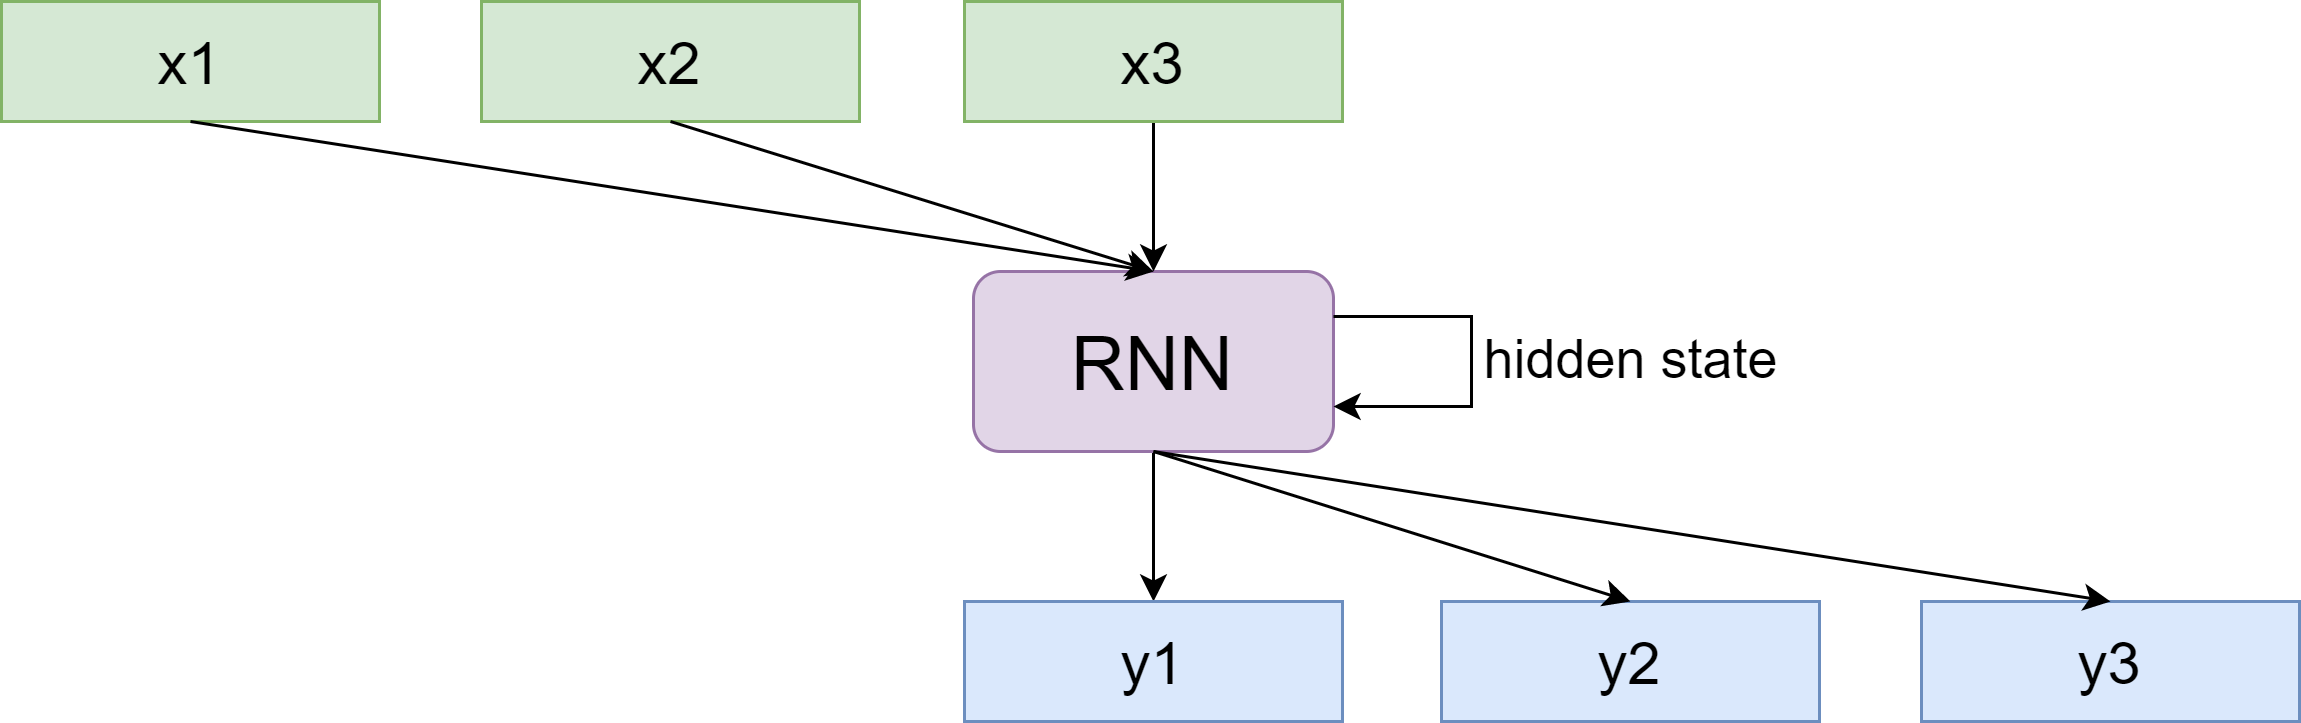

Если же развернуть работу этой сети во времени, то получится примерно такая картина:

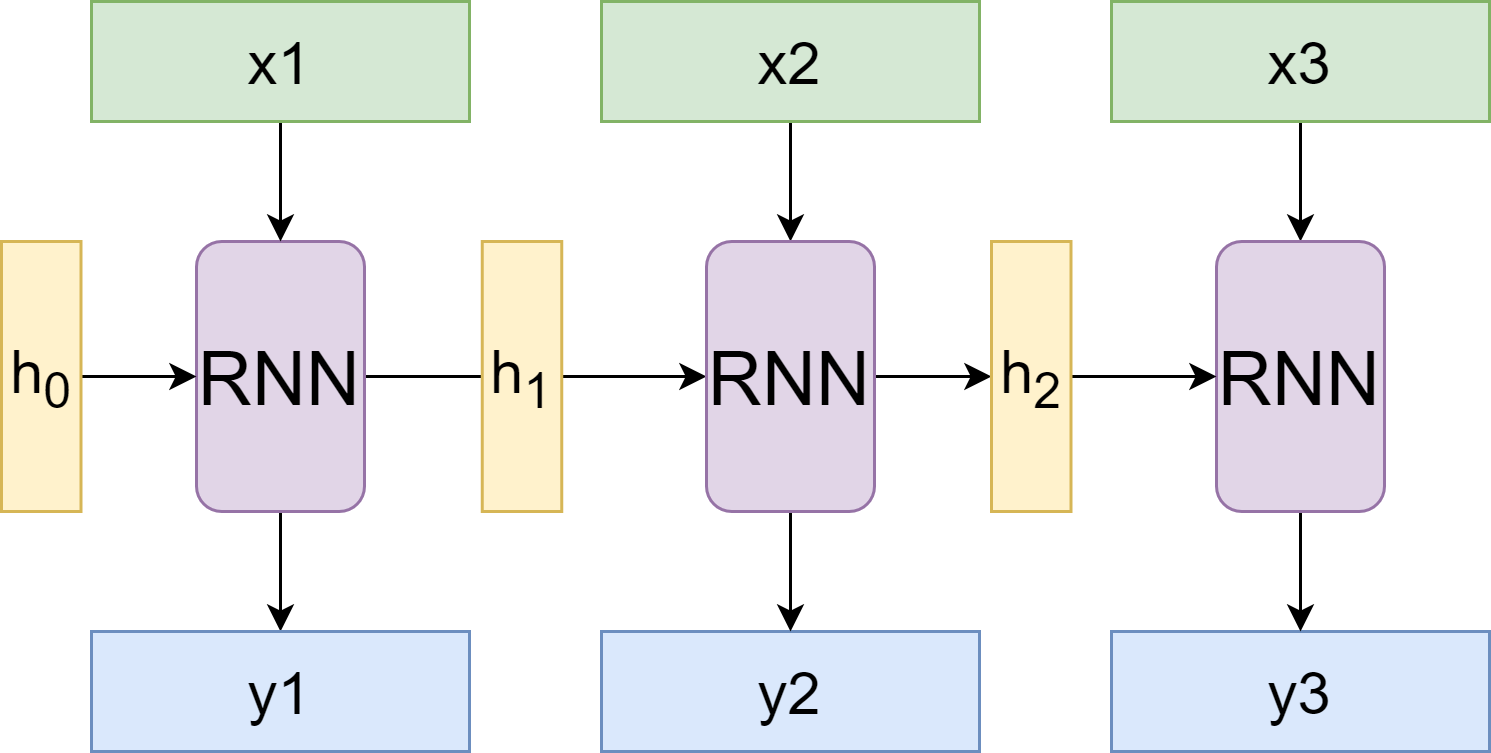

Вектор **h** это внутреннее состояние (hidden state) сети, которое помогает, при выстраивании выходной последовательности, опираться не только на текущее слово, но и на предыдущие.



---



У такой сети есть две серьезные **проблемы**:



1) Если входная последовательность будет достаточно длинной, то при обработке последних ее элементов внутреннее состояние может "забыть" о том что было в начале последовательности. (По большей части качается только простейшего варианта рекуррентной сети)

2) Так как реккурентная сеть работает с последовательностью поэлементно, то ее обучение может сильно затянуться.



# **Как эти проблемы решает трансформер?**


---


**Внимание**

Для начала стоит разобраться с одним важным понятием: **внимание**.

Как говорилось выше, элементы последовательности существуют не изолировано, а формируют смысл в первую очередь взаимодействием. **Внимание** пытается провести подсчет этого "взаимодействия".

Для этого, первым делом, разложим каждое слово последовательности на три компоненты (пропустив через три матрицы весов):

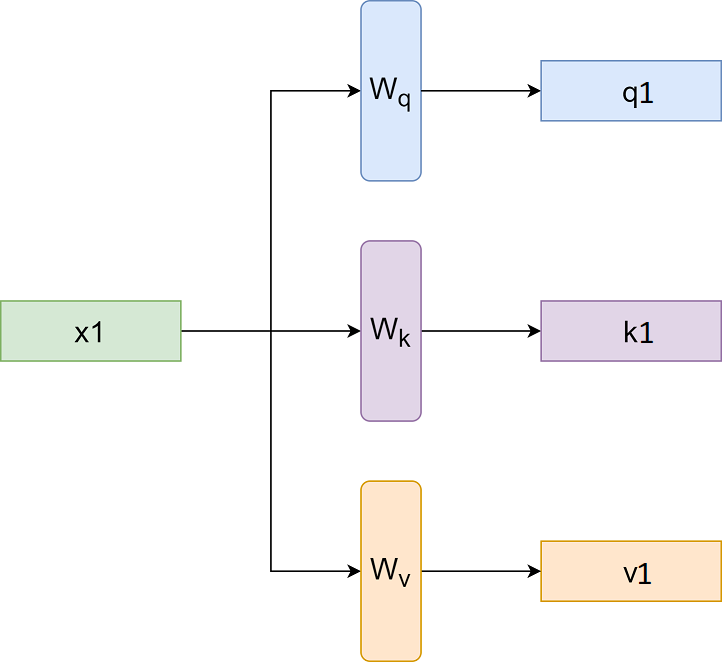

Теперь, для каждого слова, у нас есть query, key и value соответственно.

Хорошо было бы придумать формулу, которая на основе полученных векторов могла бы связывать слова последовательности и вычисляла для них внимание =)

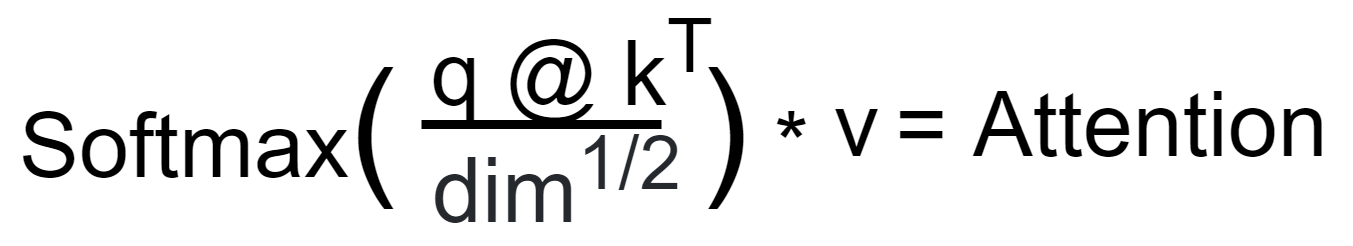

А вот и она) 

Первое на что стоит обратить внимание: мы уже работаем не с векторами query, key и value а с матрицами, полученными после обработки всей последовательности, что позволит нам получить сразу матрицу **внимания** т.е. величину связи каждого слова с каждым.

Второе - dim это размерность векторов query, key и value. Деление на корень размерности помогает сделать обучение более стабильным. (Softmax - построчный)

**Множественное внимание**

Хорошей практикой также является получить несолько таких матриц внимания, которые, стоит надеяться, будут указывать на различные взаимодействия между словами.
Например, первая матрица уловит связь между подлежащим и сказуемым, а вторая между существительным и прилагательным и т.д.

После чего можно сконкатенировать полученные матрицы, прогнать через матрицу весов и получить итоговую матрицу, которая будет содержать все знания, которые мы смогли вытащить из последовательности.

Таким образом мы получим матрицу **множественного внимания**.

# **С этим уже можно работать)**



---


**Архитектура трансформера**

Теперь следует создать сеть, которая, используя понятие **множественного внимания**, сможет решать задачи типа seq2seq. 

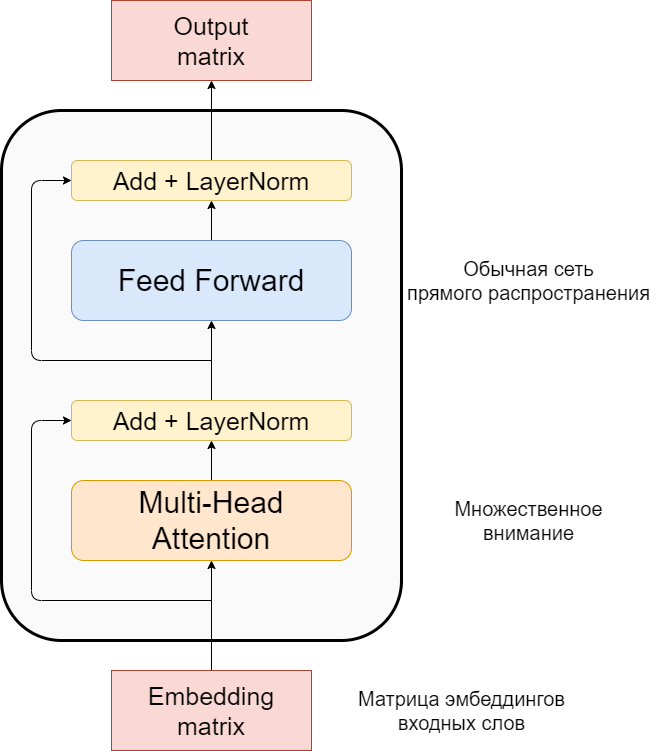

Как видно выше, входные эмбеддинги проходят через слой множественного внимания, а после - через сеть прямого распространения, которая состоит из двух слоев: у первого функция активации - ReLU, у второго она линейна.

Также есть сквозные связи, которые включают Layer-нормализацию.

**Энкодер**

Слои изображенные выше (FeedForward и Multi-HeadAttention) на самом деле правильнее называть подслоями, которые состовляют типичный слой для трансформера, который на рисунке выделен в своеобразный блок (вы же не подумали что изображенного выше будет достаточно?=)).

Из этих слоев довольно легко можно построить энкодер (часть трансформера, которая обработает входную последовательность).

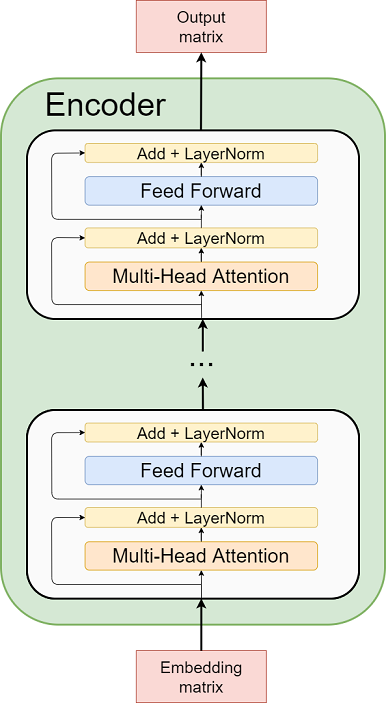

После того как входная последовательность прошла сквозь энкодер, мы получаем матрицу, в которой содержится вся информация необходимая для составления выходной последовательности.

**Декодер**

Несмотря на то что декодеру во время генерации выходной последовательности нужно опираться на входную последовательность и на предыдущие элементы выходной, его архитектура почти такая же как у энкодера.

Декодер также состоит из слоев с подслоями, так что достаточно просто рассмотреть один из них:

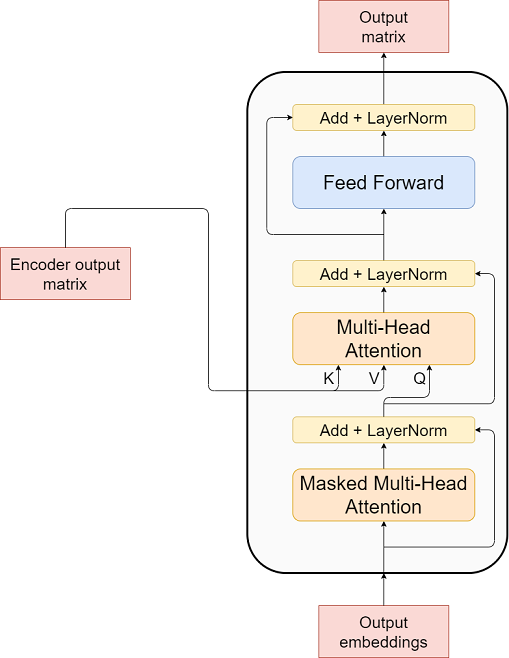

Как мы видим слой множественного внимания принимает компоненты **key** и **value** от выхода энкодера, а компоненту **query** от "выходной последовательности".

Но перед этим есть подслой masked multi-head attention, по сути это тот же слой множественного внимания, но на полученную матрицу накладывается маска, которая зануляет слова, идущие после того, которое мы хотим сгенерировать. Это заставит декодер опираться только на предыдущие позиции в выходном предложении.

**Соберем все в единое целое**

Теперь следует посмотреть на трансформер целиком (картинка из оригинальной статьи):

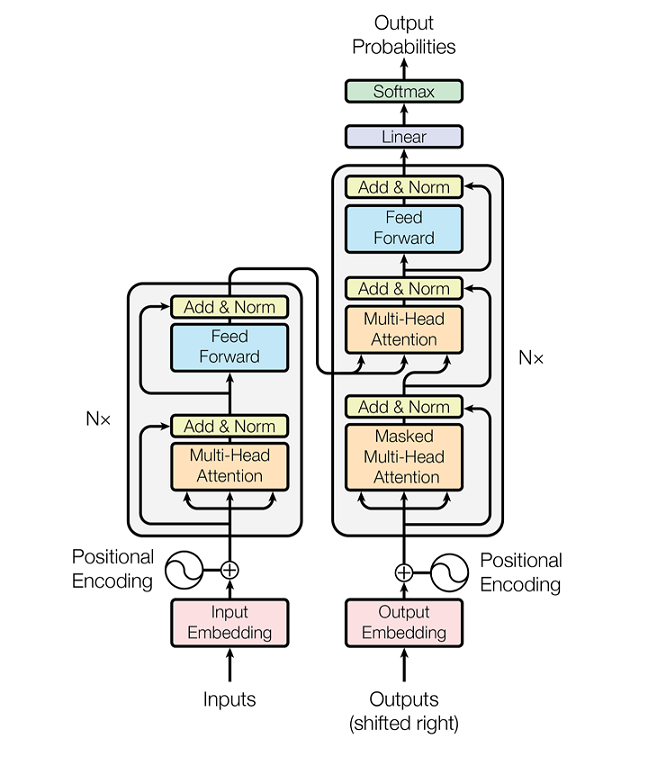

Мы разобрали все что изображено на картинке ваше, помимо некого Positional Encoding. Как следует из названия, к входным эмбедингам слов прибавляется какое-то представление их позиции в предложении.

Эта проблема вытекает из того, что все слова последовательности подаются на вход одновременно и поэтому, в отличии от реккурентных сетей, трансформер не имеет понимания, где и какое слово находиться.

К слову этот параметр может быть и обучаемым и статичными, во втором случае можно брать значения какой-либо переодической функции (например синусоиды).

# **Практика**

Самое время посмотреть, чего можно достичь в переводе с английского на русский при помощи трансформера.

Загружем и подключаем необходимые библиотеки.

In [1]:
! pip install spacy==3.1
! python -m spacy download en
! python -m spacy download ru_core_news_sm

     |████████████████████████████████| 6.4 MB 3.8 MB/s 
     |████████████████████████████████| 456 kB 53.9 MB/s 
     |████████████████████████████████| 10.1 MB 21.9 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 623 kB 45.6 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_co

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загружеам токинезаторы из библиотеки SpaCy для английского и русского.

In [4]:
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
def tokenize_ru(text):
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

Далее создаем датасет и батч-итераторы.

In [6]:
SRC = Field(tokenize = tokenize_en, # tokenization function
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True) 

TRG = Field(tokenize = tokenize_ru, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [7]:
train_data, valid_data, test_data = TabularDataset.splits(
    path='',
    train='train_data.csv',
    validation='valid_data.csv', 
    test='test_data.csv', 
    format='csv',
    fields=[('en', SRC), ('ru', TRG)])

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_sizes=(128, 128, 128),
     sort_key=lambda x: len(x.en),
     sort_within_batch=False,
     device = device)

Далее непосредственно слои трансформера.

In [11]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, src1, src2, src3, mask = None):
        batch_size = src1.shape[0]

        Q = self.fc_q(src1)
        K = self.fc_k(src2)
        V = self.fc_v(src3)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.hid_dim)

        x = self.fc_o(x)

        return x



In [12]:
class FeedForwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
      x = self.dropout(torch.relu(self.fc_1(x)))

      x = self.fc_2(x)

      return x

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.multi_head_attention_layer = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.feedforward_layer = FeedForwardLayer(hid_dim, pf_dim, dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):

        attention = self.multi_head_attention_layer(x, x, x, mask)
        x = self.self_attn_layer_norm(x + self.dropout(attention))

        temp = self.feedforward_layer(x)
        x = self.ff_layer_norm(x + self.dropout(temp))

        return x

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        
        super().__init__()

        self.device = device

        self.token_embedding = nn.Embedding(input_dim, hid_dim)
        self.positional_emdeding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
                                     EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                     for i in range(n_layers)
                                     ])
        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, x, mask):

        batch_size = x.shape[0]
        x_len = x.shape[1]

        pos = torch.arange(0, x_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        x = self.dropout(self.token_embedding(x) * self.scale + self.positional_emdeding(pos))

        for layer in self.layers:
            x = layer(x, mask)
        
        return x

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.multi_head_attention_layer = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        self.encoder_multi_head_attention_layer = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attn_layer_norm = nn.LayerNorm(hid_dim)
        
        self.feedforward_layer = FeedForwardLayer(hid_dim, pf_dim, dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_x, decoder_mask, mask):

        attention = self.multi_head_attention_layer(x, x, x, decoder_mask)
        x = self.self_attn_layer_norm(x + self.dropout(attention))

        dec_attention = self.encoder_multi_head_attention_layer(x, encoder_x, encoder_x, mask)
        x = self.encoder_attn_layer_norm(x + self.dropout(dec_attention))

        temp = self.feedforward_layer(x)
        x = self.ff_layer_norm(x + self.dropout(temp))

        return x

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        
        super().__init__()

        self.device = device

        self.token_embedding = nn.Embedding(output_dim, hid_dim)
        self.positional_emdeding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([
                                     DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                     for i in range(n_layers)
                                     ])

        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, x, enc_src, trg_mask, src_mask):

        batch_size = x.shape[0]
        x_len = x.shape[1]

        pos = torch.arange(0, x_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        x = self.dropout(self.token_embedding(x) * self.scale + self.positional_emdeding(pos))

        for layer in self.layers:
            x = layer(x, enc_src, trg_mask, src_mask)

        x = self.out(x)
        
        return x

In [17]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.device = device

    def src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(1)

    def trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(1)

        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device))

        return trg_pad_mask * trg_sub_mask

    def forward(self, src, trg):
        src_mask = self.src_mask(src)
        trg_mask = self.trg_mask(trg)

        encoder_out = self.encoder(src, src_mask)

        decoder_out = self.decoder(trg, encoder_out, trg_mask, src_mask)

        return decoder_out

Теперь можно приступить к обучению!

In [18]:

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

encoder = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

decoder = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [19]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Transformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [20]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [21]:
model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (token_embedding): Embedding(11175, 256)
    (positional_emdeding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feedforward_layer): FeedForwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)

In [22]:
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_function = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [23]:
def train(model, iterator, optimizer, loss_function, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.en
        trg = batch.ru
        
        optimizer.zero_grad()
        
        output = model(src, trg[:,:-1])
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
            
        loss = loss_function(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, loss_function):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.en
            trg = batch.ru

            output = model(src, trg[:,:-1])
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            loss = loss_function(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, loss_function, CLIP)
    valid_loss = evaluate(model, valid_iterator, loss_function)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [27]:
model.load_state_dict(torch.load('transformer_model.pt'))

test_loss = evaluate(model, test_iterator, loss_function)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.794 | Test PPL:   2.213 |


Также можно взять какое либо предложение из тестового датасета и сравнить перевод трансформера с реальным.

In [33]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    tokens = [src_field.init_token] + sentence + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.trg_mask(trg_tensor)
        
        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [50]:
example_idx = 57

src = vars(test_data.examples[example_idx])['en']
trg = vars(test_data.examples[example_idx])['ru']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['in', 'theory', ',', 'there', 'is', 'no', 'difference', 'between', 'theory', 'and', 'practice', '.', 'but', ',', 'in', 'practice', ',', 'there', 'is', '.']
trg = ['теоретически', 'нет', 'никакой', 'разницы', 'между', 'теорией', 'и', 'практикой', ',', 'но', 'на', 'практике', 'разница', 'имеется', '.']


In [51]:
translation = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['в', 'теории', 'между', 'практикой', 'и', 'теорией', 'нет', 'разницы', ',', 'но', 'на', 'практике', 'она', 'есть', '.', '<eos>']
